In [5]:
import pandas as pd

from sklearn.ensemble import RandomForestClassifier, VotingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

import matplotlib.pyplot as plt
import numpy as np

from sklearn import linear_model

from sklearn.externals import joblib
from sklearn.model_selection import cross_val_score
import time
from TypingPattern import TypingPattern
from pymongo.mongo_client import MongoClient

In [6]:
nObservations = 0
numberOfClassifiers = 3

In [7]:
client = MongoClient('localhost', 27017)
db = client['myDB']
collection = db["autenticacion"]

In [8]:
j = 0
records = []

In [9]:
for t in collection.find({}):
    try:
      typingPattern = TypingPattern()
      j = j + 1
      typingPattern.tiemposDeVuelo = [float(i) for i in t["tiemposDeVuelo"]]
      typingPattern.tiemposDePulsacion = [float(i) for i in t["tiemposDePulsacion"]]
      typingPattern.tiempoQueTardaEnTeclearLaFrase = float(t["tiempoQueTardaEnTeclearLaFrase"])
      typingPattern.target = int(t["target"])
      records.append(typingPattern.toTuple())
    except ValueError,e:
      print "error : ",e, " element ", j

In [82]:
features = ["tiempoMedioDePulsacionDeLasTeclasDeLaPrimeraFila", "tiempoMedioDePulsacionDeLasTeclasDeLaSegundaFila", 
              "tiempoMedioPulsacionDeLaT", "tiempoMedioPulsacionDeLaR", "tiempoMedioPulsacionDeLaE", "tiempoMedioPulsacionDeLaS", 
              "tiempoMedioPulsacionDeLaI", "tiempoMedioPulsacionDelEspacio", "tiempoMedioPulsacionDeLaG", 
              "tiempoDeVueloDeTaR", "tiempoDeVueloDeRaE", "tiempoDeVueloDeEaS", "tiempoDeVueloDeSaEspacio",
              "tiempoDeVueloDeEspacioaT", "tiempoDeVueloDeRaI", "tiempoDeVueloDeIaS", "tiempoDeVueloDeSaT",
              "tiempoDeVueloDeTaE", "tiempoDeVueloDeTaI", "tiempoDeVueloDeIaG", "tiempoDeVueloDeGaR",
              "tiempoQueTardaEnTeclearLaFrase", "varianzaDeLosTiemposDePulsacion"]

In [83]:
target = "target"

In [84]:
labels =  features + [target]

In [244]:
df = pd.DataFrame.from_records(records, columns = labels)

In [245]:
df.head(5)

,tiempoMedioDePulsacionDeLasTeclasDeLaPrimeraFila,tiempoMedioDePulsacionDeLasTeclasDeLaSegundaFila,tiempoMedioPulsacionDeLaT,tiempoMedioPulsacionDeLaR,tiempoMedioPulsacionDeLaE,tiempoMedioPulsacionDeLaS,tiempoMedioPulsacionDeLaI,tiempoMedioPulsacionDelEspacio,tiempoMedioPulsacionDeLaG,tiempoDeVueloDeTaR,...,tiempoDeVueloDeRaI,tiempoDeVueloDeIaS,tiempoDeVueloDeSaT,tiempoDeVueloDeTaE,tiempoDeVueloDeTaI,tiempoDeVueloDeIaG,tiempoDeVueloDeGaR,tiempoQueTardaEnTeclearLaFrase,varianzaDeLosTiemposDePulsacion,target
0,282.581818,76.52,664.550,62.00,67.500000,76.025,61.85,84.40,78.5,219.40,...,123.7,90.1,146.1,79.0,78.8,236.1,67.6,3273.7,2.621398e+05,1
1,1215.454545,67.50,3213.275,67.45,78.700000,67.500,72.95,67.50,67.5,230.55,...,179.9,112.5,123.8,90.0,101.2,202.6,78.7,2925.1,7.475225e+06,1
2,1215.454545,67.50,3213.275,67.45,78.700000,67.500,72.95,67.50,67.5,230.55,...,179.9,112.5,123.8,90.0,101.2,202.6,78.7,2925.1,7.475225e+06,1
3,286.581818,78.76,667.075,61.90,75.033333,78.725,67.60,78.85,78.9,241.75,...,112.6,135.0,168.7,1158.8,191.3,281.5,89.9,4578.7,2.642004e+05,1
4,233.727273,69.74,524.525,67.50,63.833333,70.300,73.20,84.25,67.5,292.35,...,146.4,123.8,866.1,101.3,78.8,202.4,101.3,4297.4,1.619025e+05,1


In [246]:
print "Before filtering : ", df.shape[0]

Before filtering :  385


In [247]:
for feature in features:
    if "tiempoDeVuelo" in feature:
        df = df[df[feature] <= 600]
    elif "tiempoMedioDePulsacion" in feature:
        df = df[df[feature] <= 300]
        
#Si el usuario se ha quedado esperando demasiado tiempo
#para completar la frase no es una buena medida
#del tiempo que ha tardado en escribirla
df = df[df.tiempoQueTardaEnTeclearLaFrase <= 10000]

In [248]:
print "After filtering: ", df.shape[0]

After filtering:  329


In [256]:
def plot(feature):
    esSergio = df[df.target == 1]
    noEsSergio = df[df.target == 0]
     
    N = 200
    x1 = esSergio[feature].head(N)
    y1 = esSergio["target"].head(N)

    sergioPlot = plt.scatter(x1, y1, color='r', alpha=0.5, marker='x')

    x2 = noEsSergio[feature].head(N)
    y2 = noEsSergio["target"].head(N)

    noSergioPlot = plt.scatter(x2, y2, color='g', alpha=0.5, marker='o', label = "No es Sergio")

    plt.legend((sergioPlot, noSergioPlot), ('Sergio', 'No Sergio'),
           scatterpoints=1,
           loc='right',
           ncol=3,
           fontsize=8)
    
    plt.title(feature)
    plt.xlim(0,500)

    plt.show()

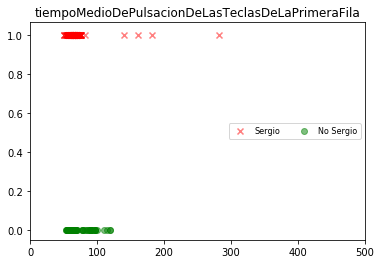

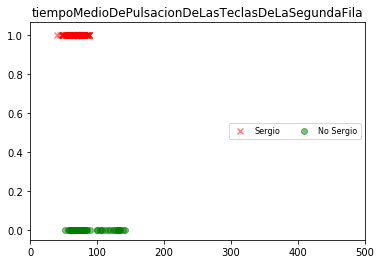

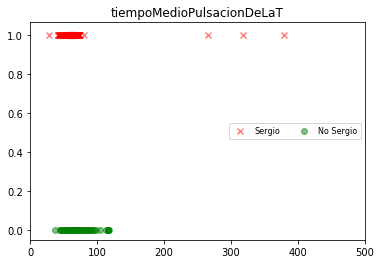

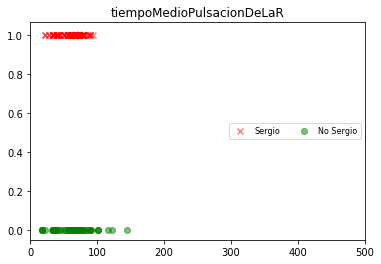

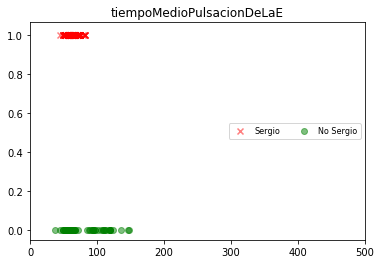

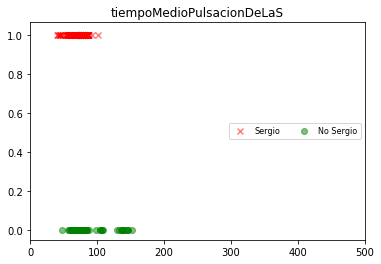

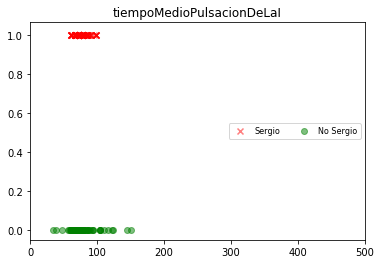

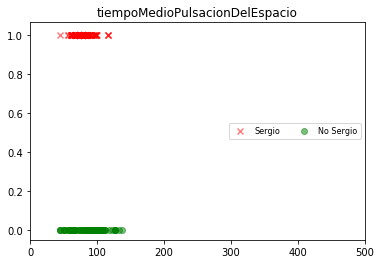

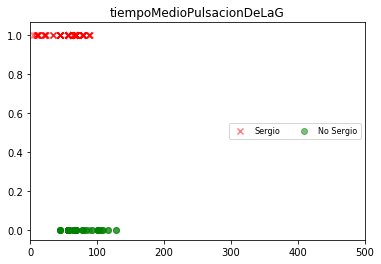

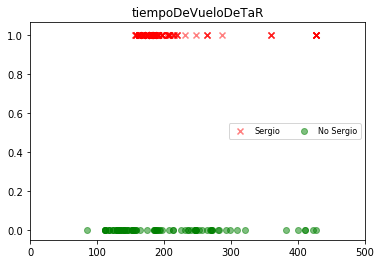

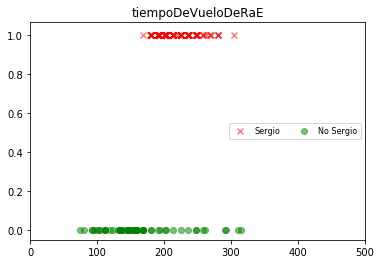

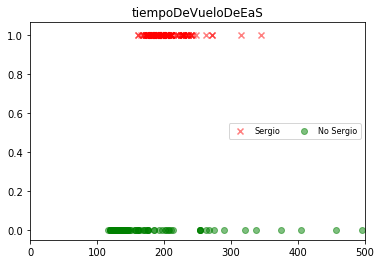

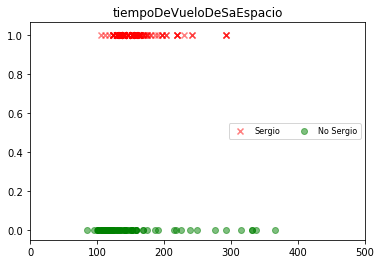

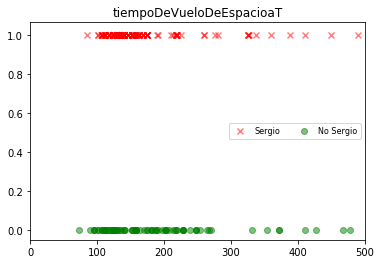

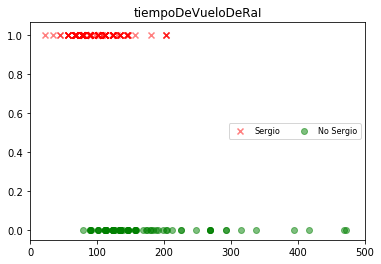

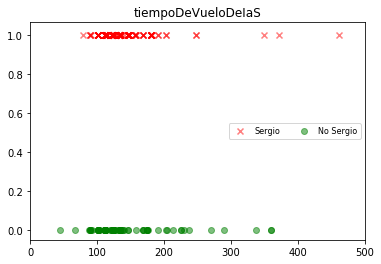

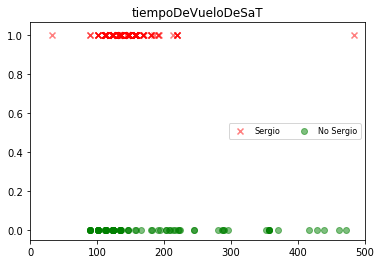

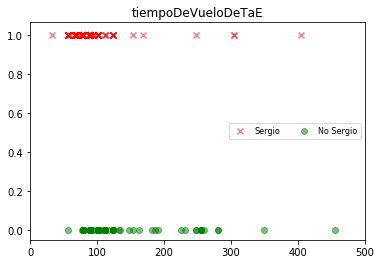

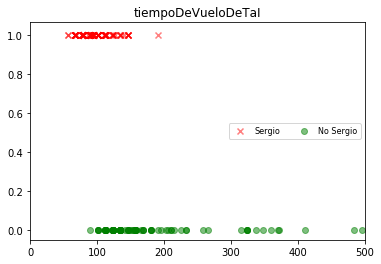

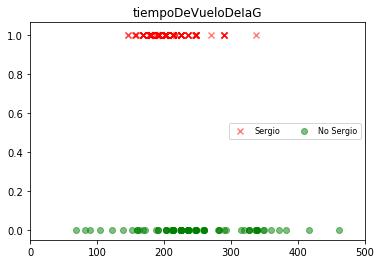

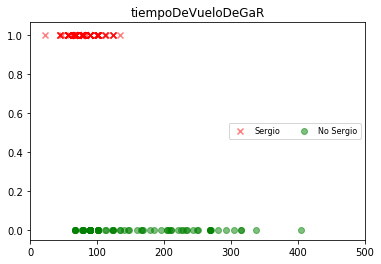

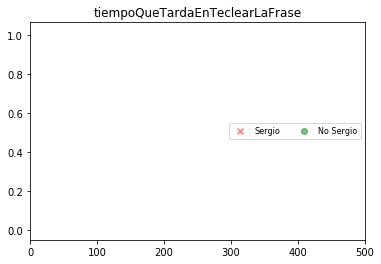

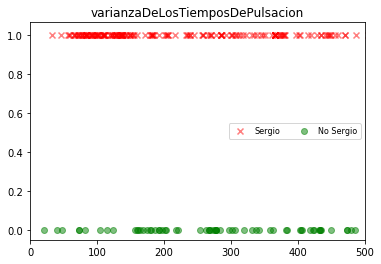

In [257]:
for feature in features:
    plot(feature)

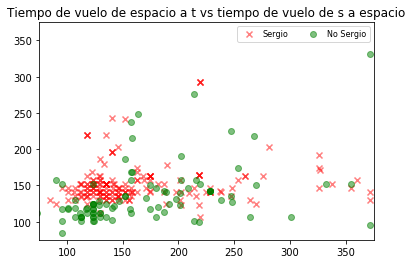

In [144]:
esSergio = df[df.target == 1]
noEsSergio = df[df.target == 0]
     
N = 200
x1 = df["tiempoDeVueloDeEspacioaT"].head(N)
y1 = esSergio["tiempoDeVueloDeSaEspacio"].head(N)


sergioPlot = plt.scatter(x1, y1, color='r', alpha=0.5, marker='x')

x2 = noEsSergio["tiempoDeVueloDeEspacioaT"].head(N)
y2 = noEsSergio["tiempoDeVueloDeSaEspacio"].head(N)


noSergioPlot = plt.scatter(x2, y2, color='g', alpha=0.5, marker='o', label = "No es Sergio")

plt.legend((sergioPlot, noSergioPlot), ('Sergio', 'No Sergio'),
           scatterpoints=1,
           loc='best',
           ncol=3,
           fontsize=8)
    
plt.title("Tiempo de vuelo de espacio a t vs tiempo de vuelo de s a espacio")
plt.xlim(75, 375)
plt.ylim(75, 375)

plt.show()

In [214]:
clf = RandomForestClassifier(n_estimators=250, random_state=0)

In [258]:
X = df[features]
y = df[target]

In [259]:
featuresToDrop = ["varianzaDeLosTiemposDePulsacion"]

for feature in featuresToDrop:
    X = X.drop(feature, axis=1)

In [157]:
X.head(5)

,tiempoMedioDePulsacionDeLasTeclasDeLaPrimeraFila,tiempoMedioDePulsacionDeLasTeclasDeLaSegundaFila,tiempoMedioPulsacionDeLaT,tiempoMedioPulsacionDeLaR,tiempoMedioPulsacionDeLaE,tiempoMedioPulsacionDeLaS,tiempoMedioPulsacionDeLaI,tiempoMedioPulsacionDelEspacio,tiempoMedioPulsacionDeLaG,tiempoDeVueloDeTaR,...,tiempoDeVueloDeRaI,tiempoDeVueloDeIaS,tiempoDeVueloDeSaT,tiempoDeVueloDeTaE,tiempoDeVueloDeTaI,tiempoDeVueloDeIaG,tiempoDeVueloDeGaR,tiempoQueTardaEnTeclearLaFrase,varianzaDeLosTiemposDePulsacion,division
11,71.545455,74.32,70.250,78.65,67.500000,78.800,73.10,78.85,56.4,208.10,...,123.8,112.5,483.7,78.8,67.3,213.8,78.7,3532.4,137.584266,0.628489
18,181.618182,60.66,378.475,78.60,63.866667,67.425,67.55,78.70,33.6,219.35,...,90.0,539.8,101.3,112.7,78.9,269.8,112.7,5399.9,66224.145305,1.106984
20,160.563636,74.22,317.900,61.80,74.933333,73.100,73.10,45.00,78.7,185.55,...,101.3,461.1,123.9,101.2,67.6,225.0,78.6,3228.8,45596.794874,0.934633
21,74.609091,76.48,73.000,72.95,75.133333,81.550,78.70,78.75,56.2,360.05,...,202.4,101.2,146.3,78.6,78.7,224.9,67.7,3723.7,149.920055,0.714867
22,74.609091,76.48,73.000,72.95,75.133333,81.550,78.70,78.75,56.2,360.05,...,202.4,101.2,146.3,78.6,78.7,224.9,67.7,3723.7,149.920055,0.714867


In [260]:
clf.fit(X, y)
scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
print("Accuracy: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std()))

Accuracy: 0.9939 (+/- 0.0074)


In [253]:
print clf.feature_importances_

[0.01157572 0.01540881 0.00543032 0.00457208 0.02875264 0.01192028
 0.00903098 0.01904995 0.00525708 0.07181298 0.21059759 0.1486942
 0.04876072 0.00547367 0.075662   0.00460633 0.02661219 0.02005053
 0.12511604 0.04008317 0.08121628 0.02313521 0.00718122]


In [254]:
print "Most important feature: ", features[np.argmax(clf.feature_importances_)]
print "Importance: ", np.max(clf.feature_importances_)

Most important feature:  tiempoDeVueloDeRaE
Importance:  0.21059759267386413


In [255]:
print "Less important feature: ", features[np.argmin(clf.feature_importances_)]
print "Importance: ", np.min(clf.feature_importances_)

Less important feature:  tiempoMedioPulsacionDeLaR
Importance:  0.004572079409865797
